In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap

In [ ]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

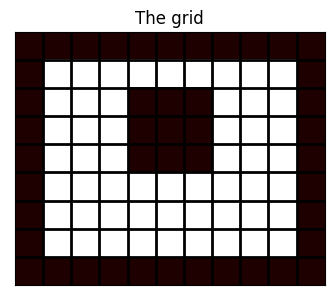

In [4]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate

    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0, 10,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._terminal_state = (3, 8)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy


  @property
  def number_of_states(self):
      return self._number_of_states


  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca() # 'get current axis'
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"", ha='center', va='center')
    plt.text(8, 3, r"", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self, terminal = False):
    if terminal:
      y, x = self._terminal_state
    else:
      y, x = self._state

    # Flatten state: rows*#columns + column
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(self._layout)
    s[y, x] = 4
    return s

  def get_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]

    return y, x

  # Environment: given an action as input, return [state, reward]
  def step(self, action):
    y, x = self._state

    # Next state
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    # Next reward (wind)
    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
    else:  # a goal
      reward = self._layout[new_y, new_x]
      new_state = (new_y, new_x)

    # Add noise to the reward (?)
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)

    self._state = new_state

    return reward, self.get_obs()

grid = Grid()
grid.plot_grid()

In [6]:


class Sarsa:
  def __init__(self, grid, number_of_actions, step_size=0.1, eps = 0.1):
    self._action_values = np.zeros((grid._number_of_states, number_of_actions))
    self._number_of_actions = number_of_actions
    self._grid = grid # environment
    self._step_size = step_size
    self._eps = eps

  def run(self, K, discount):
    """
    Run Monte Carlo control algorithm
    Args:
      K (int): total number of sampled episodes
      discount (float): future reward discount value (gamma in Sutton & Barto).
    """
    for k in range(K):
      self.episode(discount)

  def episode(self, discount):
    """
    Sample and episode.
    """
    # initialization
    s = self._grid.get_obs()
    a = np.random.randint(0, self._number_of_actions)

    # terminal state
    T = self._grid.get_obs(terminal = True)
    while s != T:
      r, next_state = self._grid.step(a)
      next_action = self.eps_greedy(next_state) # eps-greedy policy

      current_value = self._action_values[s, a]
      next_value = self._action_values[next_state, next_action]
      update = self._step_size*(r + discount*next_value - current_value)
      self._action_values[s, a] += update

      s = next_state
      a = next_action

    # reset grid to start state
    self._grid._state = self._grid._start_state


  def eps_greedy(self, s):
    """
    Args:
      s (int): current state
    Returns:
      next_action (int): refer to Grid() class for action encoding
    """

    # Pick next action eps-greedily
    greedy = np.random.choice([True, False], p=[1-self._eps, self._eps])
    if greedy:
      return self._action_values[s, :].argmax()

    return np.random.randint(0, self._number_of_actions)

In [7]:
start = time.time()
K = 100000
sarsa = Sarsa(grid, 4, eps = 0.1)
sarsa.run(K, 0.9)
print(f"Execution time for {K} episodes: {time.time() - start}")

Execution time for 100000 episodes: 17.050452947616577


In [13]:
action_values = []
for a in range(4):
  action_grid = np.copy(sarsa._grid._layout).astype(np.float64)
  for s, v in enumerate(sarsa._action_values[:, a]):
    y, x = sarsa._grid.get_state(s)
    action_grid[y, x] = v
  action_values.append(action_grid)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize = (7, 20))
actions = {0: 'up', 1: 'right', 2: 'down', 3:'left'}
for i in range(len(action_values)):
  ax[i].set_title(actions[i])
  heatmap(action_values[i], 7, -6, ax = ax[i])